
# Dataset Marker Analysis

This notebook performs exploratory marker analysis for synchronous-machine trajectory datasets already generated in this repository.

Scope:
- Auto-load one existing dataset (raw or preprocessed) using repository utilities.
- Compute physics-motivated trajectory markers.
- Analyze marker distributions, correlations, PCA structure, and clustering.
- Optionally correlate markers with available surrogate error data.

Notes:
- The analysis is exploratory and designed to guide directed dataset generation.
- Existing project conventions are reused (data contract, model/state ordering, loaders).


## 1) Setup and Data Loading

In [1]:

from __future__ import annotations

import json
import sys
from pathlib import Path
from typing import Any

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from src.data.preprocessed_trajectory_loader import load_trajectory_dataset_from_preprocessed
from src.data.raw_trajectory_loader import load_train_arrays_from_raw

plt.style.use("default")
pd.set_option("display.max_columns", 200)
np.set_printoptions(suppress=True, precision=6)


In [24]:

# User-facing configuration
MODEL_FLAG = "SM_AVR_GOV"              # e.g. SM4, SM6, SM_AVR_GOV
DATASET_NUMBER = 1               # dataset_v{number}
MAX_TRAJECTORIES = 2400          # use e.g. 200 for quick iteration
RANDOM_SEED = 42

# If True and both exist, prefer raw trajectory source over reconstructed preprocessed source.
PREFER_RAW_WHEN_AVAILABLE = True

# Marker table output directory (created automatically)
ANALYSIS_SUBDIR = "analysis"


In [25]:

def load_model_state_info(model_flag: str, init_conditions_dir: Path | None = None) -> dict[str, Any]:
    if init_conditions_dir is None:
        init_conditions_dir = PROJECT_ROOT / "src/conf/ic"
    guide_path = init_conditions_dir / "modellings_guide.yaml"
    if not guide_path.exists():
        raise FileNotFoundError(f"Modeling guide not found: {guide_path}")
    guide = OmegaConf.load(str(guide_path))
    for item in guide:
        if item.get("name") == model_flag:
            keys = list(item.get("keys"))
            keys_ext = list(item.get("keys_ext")) if item.get("keys_ext") is not None else []
            return {
                "keys": keys,
                "keys_ext": keys_ext,
                "full_name": item.get("full_name", model_flag),
            }
    raise ValueError(f"Model '{model_flag}' not found in {guide_path}")


def detect_dataset_layout(dataset_root: Path) -> dict[str, bool]:
    raw_dir = dataset_root / "raw"
    train_dir = dataset_root / "train"
    test_dir = dataset_root / "test"

    has_raw = raw_dir.exists() and any(raw_dir.glob("*.pkl"))
    has_pre = (
        train_dir.exists()
        and test_dir.exists()
        and any(train_dir.glob("*data*.h5"))
        and any(test_dir.glob("*data*.h5"))
    )
    return {"has_raw": has_raw, "has_preprocessed": has_pre}


def load_dataset_auto(
    dataset_dir: Path,
    model_flag: str,
    dataset_number: int,
    max_trajectories: int | None = None,
    prefer_raw: bool = True,
    seed: int = 0,
) -> dict[str, Any]:
    dataset_root = dataset_dir / model_flag / f"dataset_v{dataset_number}"
    if not dataset_root.exists():
        raise FileNotFoundError(f"Dataset root not found: {dataset_root}")

    layout = detect_dataset_layout(dataset_root)
    if not layout["has_raw"] and not layout["has_preprocessed"]:
        raise ValueError(
            f"Dataset contains neither raw PKL nor preprocessed H5 files: {dataset_root}"
        )

    loaded = False
    x_ics = y_trajs = t = None
    source = None

    if layout["has_raw"] and (prefer_raw or not layout["has_preprocessed"]):
        try:
            x_ics, y_trajs, t = load_train_arrays_from_raw(
                dataset_dir=str(dataset_dir),
                init_conditions_dir=str(PROJECT_ROOT / "src/conf/ic"),
                model_flag=model_flag,
                dataset_number=dataset_number,
                shuffle=False,
                seed=seed,
                max_samples=max_trajectories,
            )
            source = "raw"
            loaded = True
        except Exception as exc:
            if not layout["has_preprocessed"]:
                raise
            print(f"Raw loading failed ({exc}); falling back to preprocessed H5.")

    if not loaded:
        ds = load_trajectory_dataset_from_preprocessed(
            dataset_dir=str(dataset_dir),
            model_flag=model_flag,
            dataset_number=dataset_number,
            include_val_in_train=True,
        )
        x_train, y_train = ds.training_view()
        x_test, y_test = ds.test_view()
        if x_test is None or y_test is None:
            x_ics, y_trajs = x_train, y_train
        else:
            x_ics = np.concatenate([x_train, x_test], axis=0)
            y_trajs = np.concatenate([y_train, y_test], axis=0)
        if max_trajectories is not None:
            x_ics = x_ics[:max_trajectories]
            y_trajs = y_trajs[:max_trajectories]
        t = ds.time_grid
        source = "preprocessed"

    if t is None:
        raise ValueError("Could not infer shared time grid from dataset.")

    return {
        "ics": np.asarray(x_ics, dtype=np.float32),
        "trajs": np.asarray(y_trajs, dtype=np.float32),
        "time": np.asarray(t, dtype=np.float32),
        "source": source,
        "layout": layout,
        "dataset_root": dataset_root,
    }


In [26]:

state_info = load_model_state_info(MODEL_FLAG)
dataset = load_dataset_auto(
    dataset_dir=PROJECT_ROOT / "data",
    model_flag=MODEL_FLAG,
    dataset_number=DATASET_NUMBER,
    max_trajectories=MAX_TRAJECTORIES,
    prefer_raw=PREFER_RAW_WHEN_AVAILABLE,
    seed=RANDOM_SEED,
)

ics = dataset["ics"]
trajs = dataset["trajs"]
time_grid = dataset["time"]

n_traj, n_time, n_states = trajs.shape
ic_dim = ics.shape[1]

if ic_dim == len(state_info["keys"]):
    ic_names = list(state_info["keys"])
elif ic_dim == len(state_info["keys"]) + len(state_info["keys_ext"]):
    ic_names = list(state_info["keys"] + state_info["keys_ext"])
else:
    ic_names = [f"ic_{i}" for i in range(ic_dim)]

state_names = list(state_info["keys"])

print(f"Model: {MODEL_FLAG} ({state_info['full_name']})")
dataset_path = PROJECT_ROOT / "data" / MODEL_FLAG / f"dataset_v{DATASET_NUMBER}"
print(f"Dataset: {dataset_path}")
print(f"Detected layout: {dataset['layout']} -> loading source: {dataset['source']}")
print(f"Trajectories: {n_traj}")
print(f"States per trajectory: {n_states} ({state_names})")
print(f"Time points per trajectory: {n_time}")
print(f"IC dimension: {ic_dim} ({ic_names})")
print(f"Time span: [{time_grid[0]:.6f}, {time_grid[-1]:.6f}]")


Model: SM_AVR_GOV (Synchronous Machine with AVR and governor)
Dataset: /Users/jonaswiendl/local/Repos/ml-surrogates-for-power-systems/data/SM_AVR_GOV/dataset_v1
Detected layout: {'has_raw': True, 'has_preprocessed': True} -> loading source: raw
Trajectories: 2400
States per trajectory: 9 (['theta', 'omega', 'E_d_dash', 'E_q_dash', 'R_F', 'V_r', 'E_fd', 'P_sv', 'P_m'])
Time points per trajectory: 1001
IC dimension: 11 (['theta', 'omega', 'E_d_dash', 'E_q_dash', 'R_F', 'V_r', 'E_fd', 'P_sv', 'P_m', 'Vs', 'theta_vs'])
Time span: [0.000000, 1.000000]


## 2) Marker Definition

In [27]:

MARKER_BASE_NAMES = [
    "range",
    "peak_deviation",
    "total_variation",
    "mean_abs_derivative",
    "l2_derivative_energy",
    "early_energy_fraction",
    "mean_abs_second_derivative",
]


def _safe_divide(a: np.ndarray, b: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    return a / np.maximum(b, eps)


def compute_per_state_markers(trajs: np.ndarray, t: np.ndarray) -> dict[str, np.ndarray]:
    # Return marker arrays with shape (N, S), one value per trajectory/state.
    if trajs.ndim != 3:
        raise ValueError(f"Expected trajs with shape (N, T, S), got {trajs.shape}")
    if t.ndim != 1:
        raise ValueError("Expected 1D time grid.")
    if trajs.shape[1] != t.shape[0]:
        raise ValueError("Trajectory time axis does not match time grid length.")

    dt = np.diff(t)
    if np.any(dt <= 0):
        raise ValueError("Time grid must be strictly increasing.")

    x0 = trajs[:, :1, :]

    range_v = trajs.max(axis=1) - trajs.min(axis=1)
    peak_dev = np.max(np.abs(trajs - x0), axis=1)

    dx = np.diff(trajs, axis=1)
    abs_dx = np.abs(dx)
    total_variation = np.sum(abs_dx, axis=1)

    deriv = dx / dt[None, :, None]
    mean_abs_derivative = np.mean(np.abs(deriv), axis=1)

    l2_derivative_energy = np.sum((deriv ** 2) * dt[None, :, None], axis=1)

    t_mid = 0.5 * (t[:-1] + t[1:])
    t_cut = t[0] + 0.2 * (t[-1] - t[0])
    early_mask = t_mid <= t_cut
    early_energy = np.sum((deriv[:, early_mask, :] ** 2) * dt[None, early_mask, None], axis=1)
    early_energy_fraction = _safe_divide(early_energy, l2_derivative_energy)

    d1 = np.gradient(trajs, t, axis=1)
    d2 = np.gradient(d1, t, axis=1)
    mean_abs_second_derivative = np.mean(np.abs(d2), axis=1)

    return {
        "range": range_v,
        "peak_deviation": peak_dev,
        "total_variation": total_variation,
        "mean_abs_derivative": mean_abs_derivative,
        "l2_derivative_energy": l2_derivative_energy,
        "early_energy_fraction": early_energy_fraction,
        "mean_abs_second_derivative": mean_abs_second_derivative,
    }


def flatten_marker_dict(
    marker_dict: dict[str, np.ndarray],
    state_names: list[str],
) -> pd.DataFrame:
    # Create explicit per-state + aggregated marker columns.
    out: dict[str, np.ndarray] = {}
    for marker_name, values in marker_dict.items():
        if values.ndim != 2:
            raise ValueError(f"Marker '{marker_name}' must be 2D (N,S).")

        for s_idx, s_name in enumerate(state_names):
            out[f"{marker_name}_{s_name}"] = values[:, s_idx]

        out[f"{marker_name}__mean"] = values.mean(axis=1)
        out[f"{marker_name}__max"] = values.max(axis=1)

    return pd.DataFrame(out)


## 3) Compute Marker Table

In [28]:

marker_per_state = compute_per_state_markers(trajs=trajs, t=time_grid)
marker_df = flatten_marker_dict(marker_per_state, state_names=state_names)

ic_df = pd.DataFrame(ics, columns=[f"ic_{name}" for name in ic_names])
marker_table = pd.concat([ic_df, marker_df], axis=1)

analysis_dir = dataset["dataset_root"] / ANALYSIS_SUBDIR
analysis_dir.mkdir(parents=True, exist_ok=True)

parquet_path = analysis_dir / "marker_table.parquet"
csv_path = analysis_dir / "marker_table.csv"

saved_as = None
try:
    marker_table.to_parquet(parquet_path, index=False)
    saved_as = parquet_path
except Exception as exc:
    print(f"Parquet save failed ({exc}). Falling back to CSV.")
    marker_table.to_csv(csv_path, index=False)
    saved_as = csv_path

print(f"Marker table shape: {marker_table.shape}")
print(f"Saved marker table to: {saved_as}")
marker_table.head(3)


Parquet save failed (Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - `Import pyarrow` failed. pyarrow is required for parquet support. Use pip or conda to install the pyarrow package.
 - `Import fastparquet` failed. fastparquet is required for parquet support. Use pip or conda to install the fastparquet package.). Falling back to CSV.
Marker table shape: (2400, 88)
Saved marker table to: /Users/jonaswiendl/local/Repos/ml-surrogates-for-power-systems/data/SM_AVR_GOV/dataset_v1/analysis/marker_table.csv


,ic_theta,ic_omega,ic_E_d_dash,ic_E_q_dash,ic_R_F,ic_V_r,ic_E_fd,ic_P_sv,ic_P_m,ic_Vs,ic_theta_vs,range_theta,range_omega,range_E_d_dash,range_E_q_dash,range_R_F,range_V_r,range_E_fd,range_P_sv,range_P_m,range__mean,range__max,peak_deviation_theta,peak_deviation_omega,peak_deviation_E_d_dash,peak_deviation_E_q_dash,peak_deviation_R_F,peak_deviation_V_r,peak_deviation_E_fd,peak_deviation_P_sv,peak_deviation_P_m,peak_deviation__mean,peak_deviation__max,total_variation_theta,total_variation_omega,total_variation_E_d_dash,total_variation_E_q_dash,total_variation_R_F,total_variation_V_r,total_variation_E_fd,total_variation_P_sv,total_variation_P_m,total_variation__mean,total_variation__max,mean_abs_derivative_theta,mean_abs_derivative_omega,mean_abs_derivative_E_d_dash,mean_abs_derivative_E_q_dash,mean_abs_derivative_R_F,mean_abs_derivative_V_r,mean_abs_derivative_E_fd,mean_abs_derivative_P_sv,mean_abs_derivative_P_m,mean_abs_derivative__mean,mean_abs_derivative__max,l2_derivative_energy_theta,l2_derivative_energy_omega,l2_derivative_energy_E_d_dash,l2_derivative_energy_E_q_dash,l2_derivative_energy_R_F,l2_derivative_energy_V_r,l2_derivative_energy_E_fd,l2_derivative_energy_P_sv,l2_derivative_energy_P_m,l2_derivative_energy__mean,l2_derivative_energy__max,early_energy_fraction_theta,early_energy_fraction_omega,early_energy_fraction_E_d_dash,early_energy_fraction_E_q_dash,early_energy_fraction_R_F,early_energy_fraction_V_r,early_energy_fraction_E_fd,early_energy_fraction_P_sv,early_energy_fraction_P_m,early_energy_fraction__mean,early_energy_fraction__max,mean_abs_second_derivative_theta,mean_abs_second_derivative_omega,mean_abs_second_derivative_E_d_dash,mean_abs_second_derivative_E_q_dash,mean_abs_second_derivative_R_F,mean_abs_second_derivative_V_r,mean_abs_second_derivative_E_fd,mean_abs_second_derivative_P_sv,mean_abs_second_derivative_P_m,mean_abs_second_derivative__mean,mean_abs_second_derivative__max
0,0.785493,0.065282,0.0,1.075828,1.0,1.105,1.08,0.7048,0.7048,0.975221,-0.027080,0.255687,0.398101,0.0,0.005650,0.510070,9.758511,3.424091,0.015758,0.011425,1.597699,9.758511,0.255360,0.398101,0.0,0.005650,0.510070,9.758511,3.423769,0.014867,0.011338,1.597518,9.758511,0.256014,0.544350,0.0,0.005650,0.510070,14.378014,4.063585,0.023373,0.012645,2.199300,14.378014,0.256014,0.544350,0.0,0.005650,0.510070,14.378014,4.063586,0.023373,0.012645,2.199300,14.378014,0.069349,1.487772,0.0,0.000033,0.294667,535.253906,32.801723,0.001136,0.000268,63.323200,535.253906,0.188865,0.980772,0.0,0.334542,0.464681,0.927440,0.574425,0.833338,0.209726,0.501532,0.980772,0.543297,7.138140,0.0,0.022598,0.648340,96.699341,26.382982,0.279610,0.074797,14.643234,96.699341
1,0.420916,-0.340817,0.0,1.033828,1.0,1.105,1.08,0.7048,0.7048,0.998201,-0.286527,0.208003,0.207981,0.0,0.000968,0.507543,10.103451,3.509358,0.011195,0.008099,1.617400,10.103451,0.208003,0.207981,0.0,0.000942,0.507543,10.103451,3.509047,0.011195,0.008099,1.617362,10.103451,0.208003,0.207981,0.0,0.000993,0.507543,14.630418,4.126101,0.017969,0.009868,2.189875,14.630418,0.208003,0.207981,0.0,0.000993,0.507543,14.630419,4.126101,0.017969,0.009868,2.189875,14.630419,0.046050,0.060927,0.0,0.000001,0.292319,566.265991,34.446152,0.001099,0.000164,66.790306,566.265991,0.367197,0.667928,0.0,0.007981,0.467284,0.931919,0.581075,0.943389,0.590696,0.506385,0.943389,0.207497,0.758450,0.0,0.023241,0.651180,99.348366,26.973387,0.185545,0.060909,14.245397,99.348366
2,-1.639748,0.201084,0.0,1.066730,1.0,1.105,1.08,0.7048,0.7048,0.996078,0.201823,1.094549,1.042264,0.0,0.014146,0.503336,11.096874,3.685306,0.081732,0.071151,1.954373,11.096874,1.094549,1.042264,0.0,0.014146,0.503336,11.096874,3.685029,0.081732,0.071151,1.954342,11.096874,1.094549,1.357432,0.0,0.014146,0.503336,16.484406,4.413916,0.095565,0.071578,2.670547,16.484406,1.094549,1.357432,0.0,0.014146,0.503336,16.484404,4.413916,0.095565,0.071578,2.670547,16.484404,1.227026,8.843741,0.0,0.000249,0.287679,692.328552,39.797886,0.022865,0.007816,82.501755

## 4) Distribution Analysis

Aggregated marker stats:


,mean,std,cv
early_energy_fraction__max,0.979174,0.018707,0.019105
early_energy_fraction__mean,0.526278,0.048723,0.092580
l2_derivative_energy__max,657.815125,103.575562,0.157454
l2_derivative_energy__mean,78.219841,12.198335,0.155949
mean_abs_derivative__max,15.594676,1.030574,0.066085
mean_abs_derivative__mean,2.437733,0.186015,0.076306
mean_abs_second_derivative__max,105.228752,6.886408,0.065442
mean_abs_second_derivative__mean,16.539175,1.541759,0.093219
peak_deviation__max,10.941311,0.985766,0.090096
peak_deviation__mean,1.830077,0.166321,0.090882


Near-constant markers (std < 1e-8 OR cv < 1e-3):


,mean,std,cv


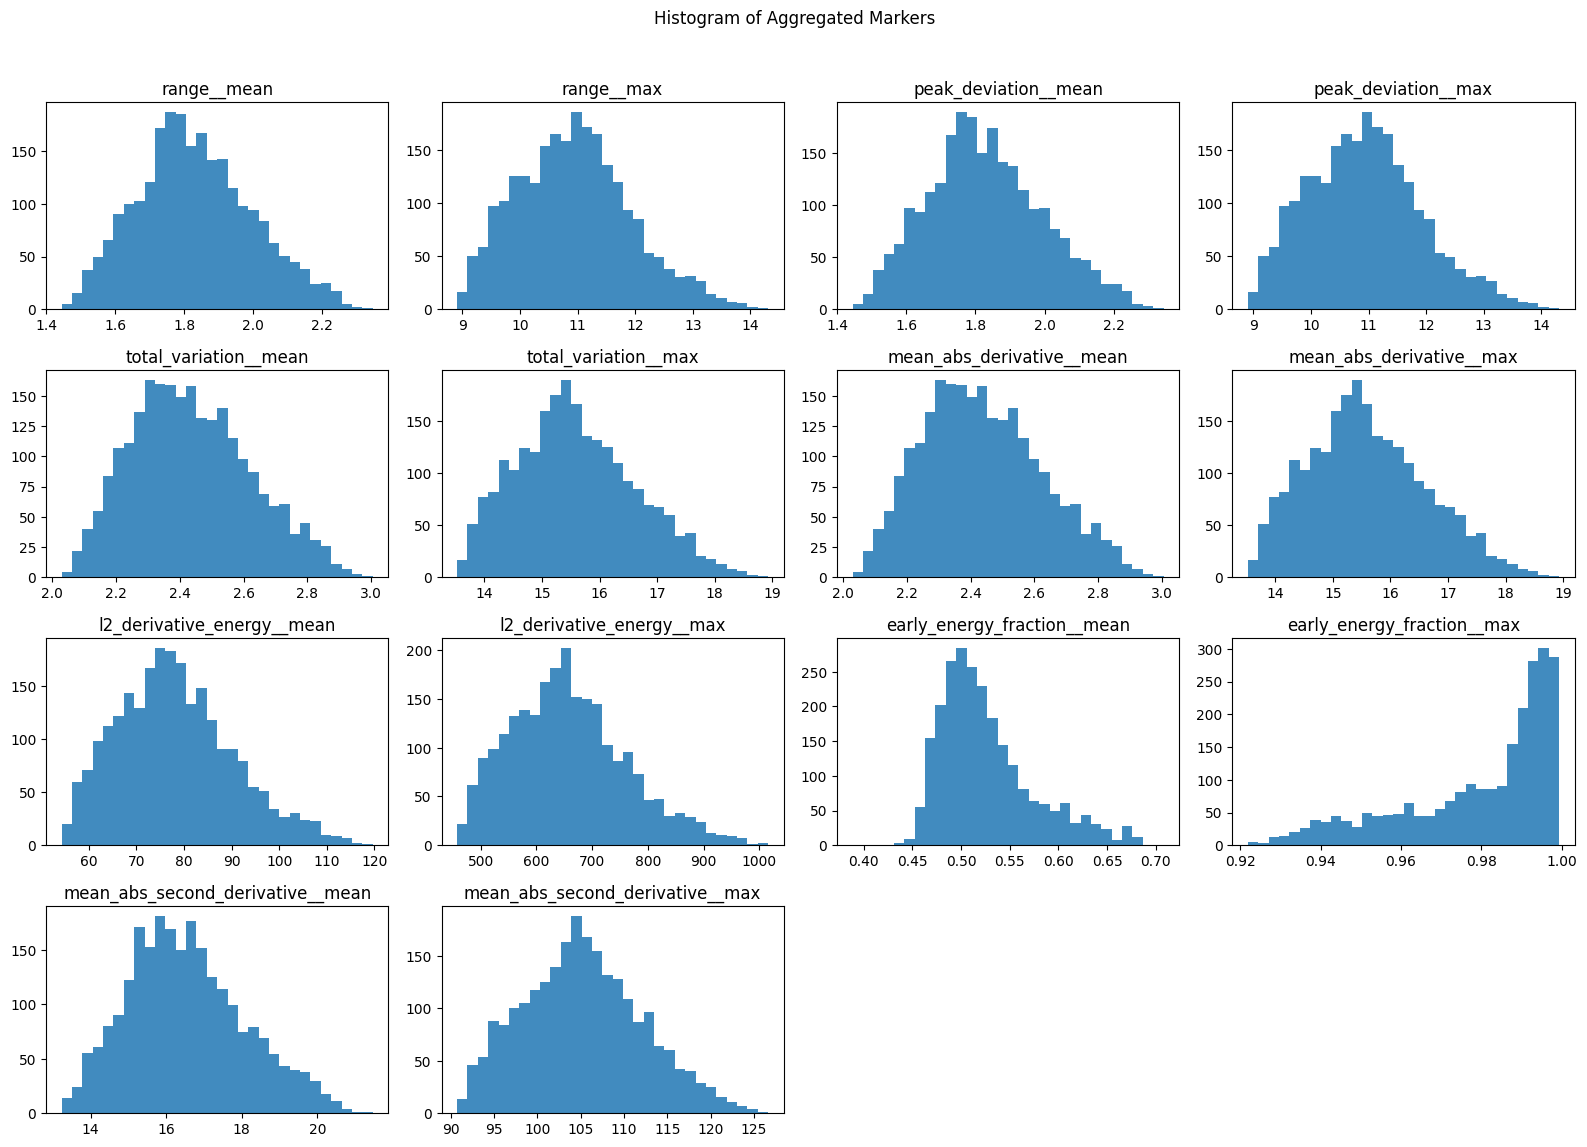

In [29]:

agg_marker_cols = [c for c in marker_table.columns if c.endswith("__mean") or c.endswith("__max")]

stats_df = pd.DataFrame({
    "mean": marker_table[agg_marker_cols].mean(),
    "std": marker_table[agg_marker_cols].std(ddof=0),
})
stats_df["cv"] = np.abs(stats_df["std"] / np.maximum(np.abs(stats_df["mean"]), 1e-12))

near_constant = stats_df[(stats_df["std"] < 1e-8) | (stats_df["cv"] < 1e-3)].sort_values("cv")

print("Aggregated marker stats:")
display(stats_df.sort_index())
print("Near-constant markers (std < 1e-8 OR cv < 1e-3):")
display(near_constant if len(near_constant) else pd.DataFrame(columns=stats_df.columns))

n_cols = 4
n_rows = int(np.ceil(len(agg_marker_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2.8 * n_rows))
axes = np.atleast_1d(axes).ravel()
for ax, col in zip(axes, agg_marker_cols):
    ax.hist(marker_table[col].values, bins=30, alpha=0.85)
    ax.set_title(col)
for ax in axes[len(agg_marker_cols):]:
    ax.axis("off")
fig.suptitle("Histogram of Aggregated Markers", y=1.02)
fig.tight_layout()
plt.show()


## 5) Correlation Analysis

Marker pairs with |corr| > 0.95: 406


,marker_a,marker_b,abs_corr
401,range_V_r,peak_deviation_V_r,1.000000
3827,l2_derivative_energy_V_r,l2_derivative_energy__max,1.000000
791,range__max,peak_deviation__max,1.000000
2111,total_variation_V_r,total_variation__max,1.000000
1253,peak_deviation_V_r,peak_deviation__max,1.000000
406,range_V_r,peak_deviation__max,1.000000
395,range_V_r,range__max,1.000000
2969,mean_abs_derivative_V_r,mean_abs_derivative__max,1.000000
334,range_R_F,total_variation_R_F,1.000000
323,range_R_F,peak_deviation_R_F,1.000000


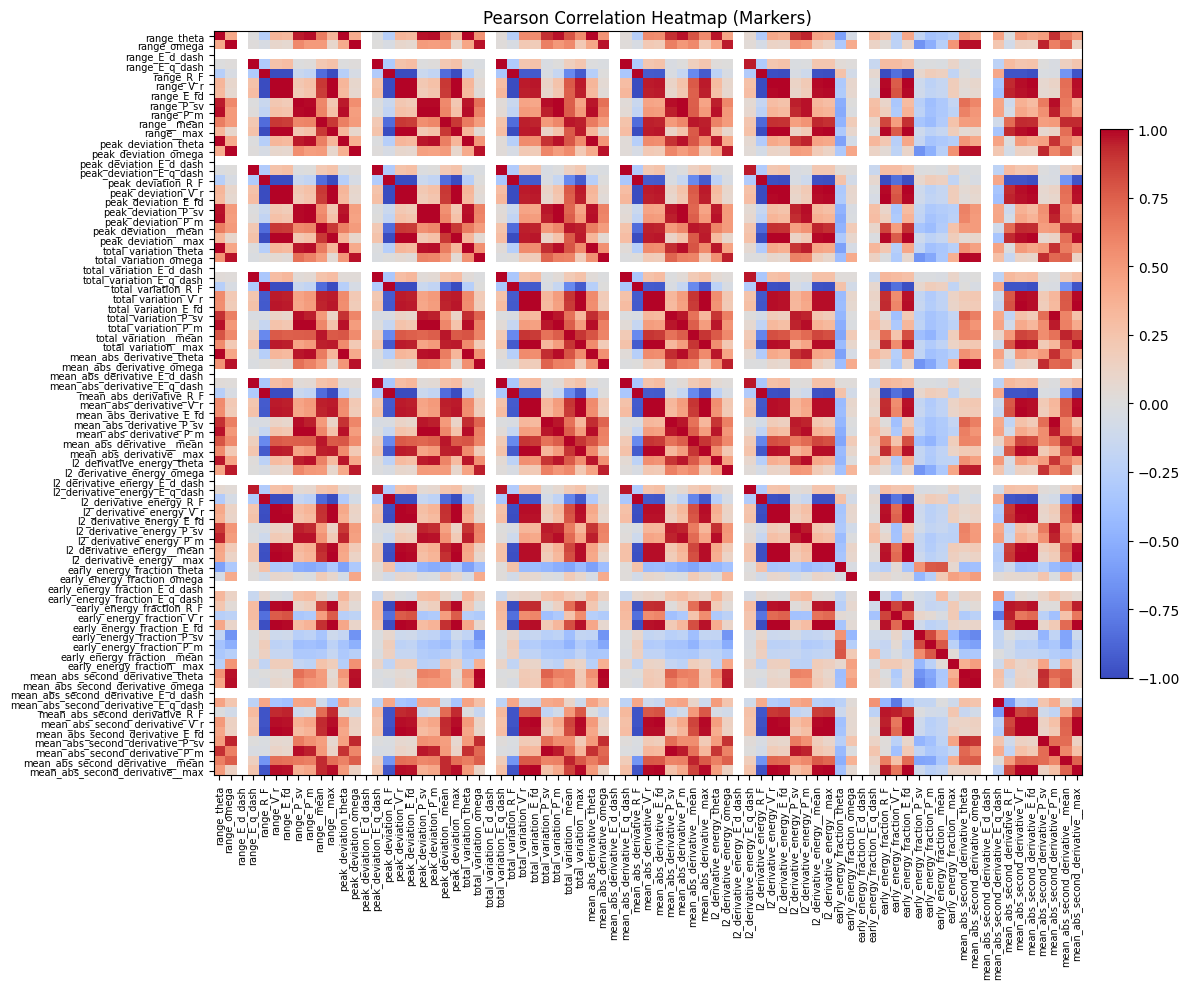

In [30]:

marker_cols = [c for c in marker_table.columns if not c.startswith("ic_")]
corr = marker_table[marker_cols].corr(method="pearson")

abs_corr = corr.abs()
mask_upper = np.triu(np.ones_like(abs_corr, dtype=bool), k=1)
pairs = (
    abs_corr.where(mask_upper)
    .stack()
    .reset_index()
    .rename(columns={"level_0": "marker_a", "level_1": "marker_b", 0: "abs_corr"})
)
high_corr_pairs = pairs[pairs["abs_corr"] > 0.95].sort_values("abs_corr", ascending=False)

print(f"Marker pairs with |corr| > 0.95: {len(high_corr_pairs)}")
display(high_corr_pairs.head(30))

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm", aspect="auto")
ax.set_title("Pearson Correlation Heatmap (Markers)")
ax.set_xticks(np.arange(len(marker_cols)))
ax.set_yticks(np.arange(len(marker_cols)))
ax.set_xticklabels(marker_cols, rotation=90, fontsize=7)
ax.set_yticklabels(marker_cols, fontsize=7)
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
fig.tight_layout()
plt.show()


## 6) PCA

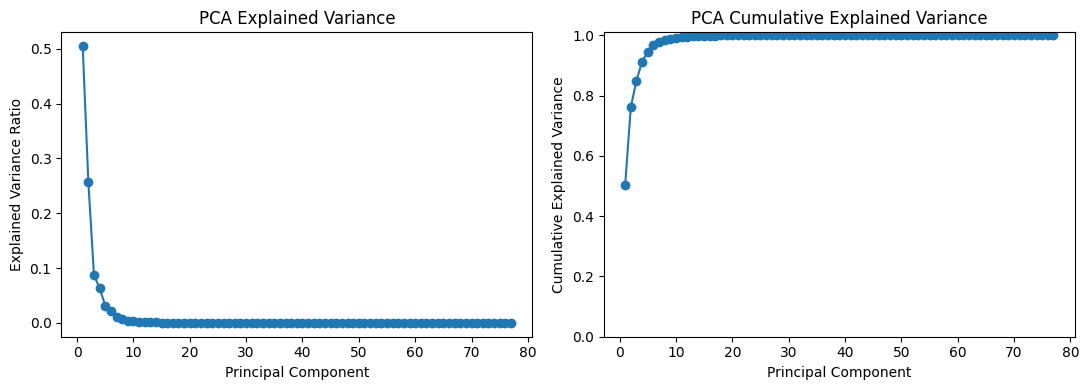

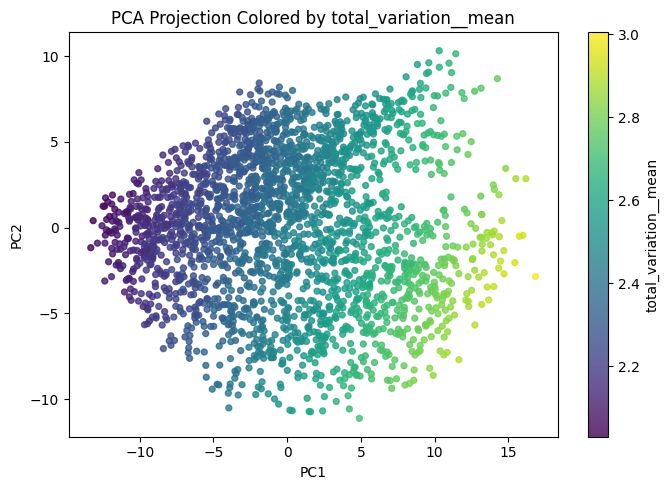

In [31]:

X = marker_table[marker_cols].to_numpy(dtype=np.float64)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA(random_state=RANDOM_SEED)
X_pca_full = pca_full.fit_transform(X_scaled)

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].plot(np.arange(1, len(explained) + 1), explained, marker="o")
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].set_title("PCA Explained Variance")

axes[1].plot(np.arange(1, len(cum_explained) + 1), cum_explained, marker="o")
axes[1].set_xlabel("Principal Component")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("PCA Cumulative Explained Variance")
axes[1].set_ylim(0, 1.01)
fig.tight_layout()
plt.show()

color_marker = "total_variation__mean" if "total_variation__mean" in marker_table.columns else marker_cols[0]

fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(
    X_pca_full[:, 0],
    X_pca_full[:, 1],
    c=marker_table[color_marker].values,
    cmap="viridis",
    s=18,
    alpha=0.8,
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"PCA Projection Colored by {color_marker}")
fig.colorbar(sc, ax=ax, label=color_marker)
fig.tight_layout()
plt.show()


## 7) Clustering

Silhouette scores:
  K=3: 0.2716
  K=4: 0.2478
  K=5: 0.2479
  K=6: 0.2473
  K=7: 0.2326
  K=8: 0.2247
Best K: 3


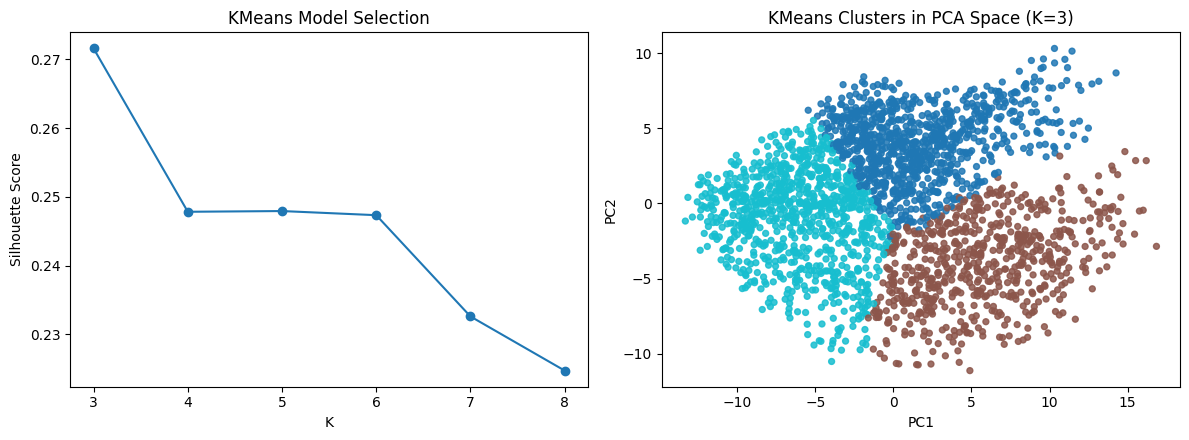

Cluster sizes:


,n_trajectories
0,886
1,637
2,877


In [32]:

k_values = list(range(3, 9))
sil_scores = []
models = {}

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    models[k] = (km, labels)

best_idx = int(np.argmax(sil_scores))
best_k = k_values[best_idx]
best_model, best_labels = models[best_k]

print("Silhouette scores:")
for k, s in zip(k_values, sil_scores):
    print(f"  K={k}: {s:.4f}")
print(f"Best K: {best_k}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
axes[0].plot(k_values, sil_scores, marker="o")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("KMeans Model Selection")

axes[1].scatter(X_pca_full[:, 0], X_pca_full[:, 1], c=best_labels, cmap="tab10", s=18, alpha=0.85)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title(f"KMeans Clusters in PCA Space (K={best_k})")
fig.tight_layout()
plt.show()

cluster_sizes = pd.Series(best_labels).value_counts().sort_index()
print("Cluster sizes:")
display(cluster_sizes.to_frame("n_trajectories"))


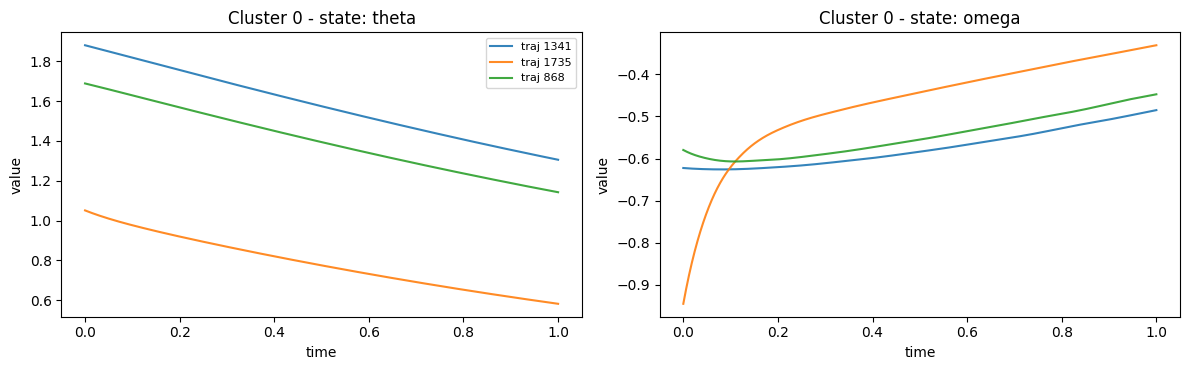

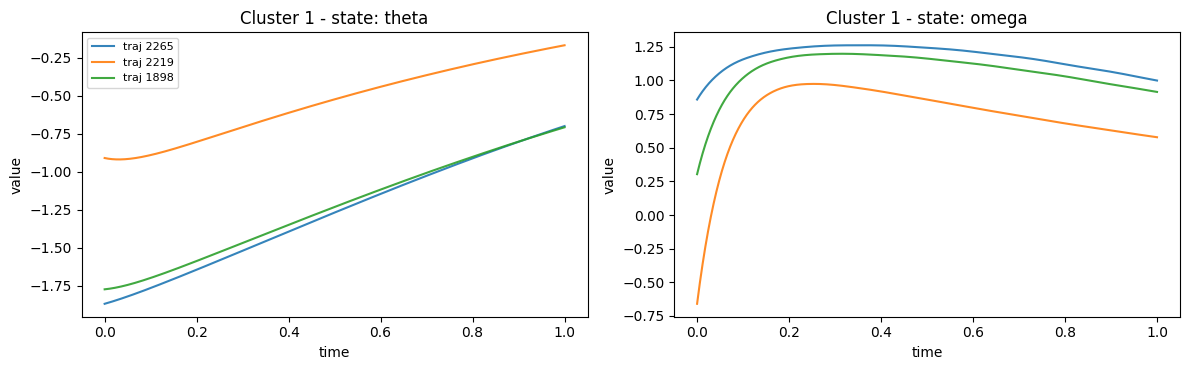

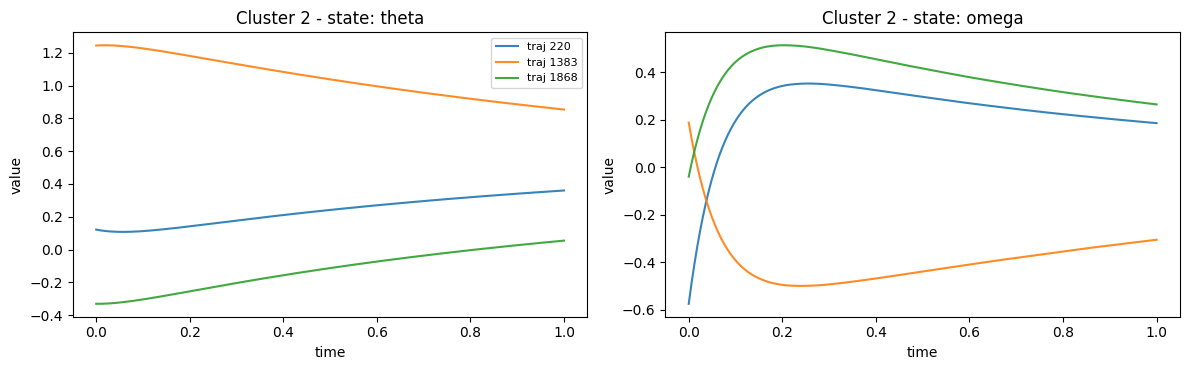

In [33]:

# Plot 2-3 representative trajectories per cluster for key states.
state_candidates = ["delta", "theta", "omega"]
plot_states = [s for s in state_candidates if s in state_names]
if not plot_states:
    plot_states = state_names[: min(2, len(state_names))]

state_to_idx = {s: i for i, s in enumerate(state_names)}
plot_state_idx = [state_to_idx[s] for s in plot_states]

X_pca_2 = X_pca_full[:, :2]
centers_2 = best_model.cluster_centers_ @ pca_full.components_[:2, :].T

for c in range(best_k):
    idx = np.where(best_labels == c)[0]
    if len(idx) == 0:
        continue

    d2 = np.sum((X_pca_2[idx] - centers_2[c]) ** 2, axis=1)
    reps = idx[np.argsort(d2)[: min(3, len(idx))]]

    fig, axes = plt.subplots(1, len(plot_state_idx), figsize=(6 * len(plot_state_idx), 3.8), sharex=True)
    axes = np.atleast_1d(axes)

    for ax, s_idx in zip(axes, plot_state_idx):
        for rid in reps:
            ax.plot(time_grid, trajs[rid, :, s_idx], alpha=0.9, label=f"traj {rid}")
        ax.set_title(f"Cluster {c} - state: {state_names[s_idx]}")
        ax.set_xlabel("time")
        ax.set_ylabel("value")

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(handles, labels, loc="best", fontsize=8)
    fig.tight_layout()
    plt.show()


## 8) Optional: Surrogate Error Correlation

In [34]:

# Set an explicit path if you have trajectory-level surrogate error values.
# Supported: .csv, .parquet, .npz, .json
ERROR_FILE: str | None = None


def discover_error_candidates(base_dir: Path) -> list[Path]:
    if not base_dir.exists():
        return []
    patterns = ["*error*", "*rmse*", "*mse*"]
    cands = []
    for pat in patterns:
        cands.extend(base_dir.rglob(pat))
    return sorted({p for p in cands if p.is_file() and p.suffix.lower() in {".csv", ".parquet", ".npz", ".json"}})


def load_error_vector(path: Path, n_expected: int) -> np.ndarray:
    suffix = path.suffix.lower()
    if suffix == ".csv":
        df = pd.read_csv(path)
        for col in ["error", "rmse", "mse", "trajectory_error", "surrogate_error"]:
            if col in df.columns:
                vec = df[col].to_numpy(dtype=float)
                break
        else:
            if df.shape[1] != 1:
                raise ValueError(f"CSV {path} must contain a known error column or a single column.")
            vec = df.iloc[:, 0].to_numpy(dtype=float)
    elif suffix == ".parquet":
        df = pd.read_parquet(path)
        for col in ["error", "rmse", "mse", "trajectory_error", "surrogate_error"]:
            if col in df.columns:
                vec = df[col].to_numpy(dtype=float)
                break
        else:
            if df.shape[1] != 1:
                raise ValueError(f"Parquet {path} must contain a known error column or a single column.")
            vec = df.iloc[:, 0].to_numpy(dtype=float)
    elif suffix == ".npz":
        data = np.load(path)
        keys = list(data.keys())
        preferred = ["error", "rmse", "mse", "trajectory_error", "surrogate_error"]
        key = next((k for k in preferred if k in keys), None)
        if key is None:
            key = next((k for k in keys if data[k].ndim == 1), None)
        if key is None:
            raise ValueError(f"Could not find a 1D error vector in {path}. Keys: {keys}")
        vec = np.asarray(data[key], dtype=float)
    elif suffix == ".json":
        payload = json.loads(path.read_text())
        if isinstance(payload, list):
            vec = np.asarray(payload, dtype=float)
        elif isinstance(payload, dict):
            key = next((k for k in ["error", "rmse", "mse", "trajectory_error", "surrogate_error"] if k in payload), None)
            if key is None:
                raise ValueError(f"Could not find supported error key in JSON: {path}")
            vec = np.asarray(payload[key], dtype=float)
        else:
            raise ValueError(f"Unsupported JSON structure in {path}")
    else:
        raise ValueError(f"Unsupported error file type: {path}")

    if vec.ndim != 1:
        raise ValueError(f"Error vector must be 1D, got shape {vec.shape}")
    if vec.shape[0] != n_expected:
        raise ValueError(
            f"Error vector length mismatch: expected {n_expected}, got {vec.shape[0]} from {path}"
        )
    return vec


In [35]:

error_candidates = discover_error_candidates(Path("outputs"))
print("Auto-discovered error-like files (first 15):")
for p in error_candidates[:15]:
    print(f"  - {p}")

error_path = Path(ERROR_FILE) if ERROR_FILE else None
if error_path is None:
    print("No ERROR_FILE set. Skipping error correlation.")
else:
    err = load_error_vector(error_path, n_expected=len(marker_table))
    corr_to_err = marker_table[marker_cols].corrwith(pd.Series(err, name="surrogate_error")).dropna()
    ranking = corr_to_err.abs().sort_values(ascending=False).to_frame("abs_corr")
    ranking["signed_corr"] = corr_to_err[ranking.index]
    print(f"Loaded error vector from: {error_path}")
    display(ranking.head(30))


Auto-discovered error-like files (first 15):
No ERROR_FILE set. Skipping error correlation.



## Notes and Suggested Next Steps

- Markers with tiny variance or extreme correlation can be removed before defining any adaptive acquisition objective.
- The PCA + clustering views can guide whether marker space captures truly distinct dynamical regimes.
- If trajectory-level surrogate error is available, the final section provides a quick relevance ranking by absolute correlation.



## 9) Reduced Marker Set Analysis

This section evaluates whether a small subset of markers (3-5 markers) is sufficient to capture meaningful dynamical regimes, without recomputing marker definitions.


### 9.1 Marker Selection

In [36]:

# Reuse existing full marker table.
df = marker_table.copy()

# Candidate pool in priority order for each role.
amplitude_candidates = ["range__max", "peak_deviation__max"]
activity_candidates = ["l2_derivative_energy__mean", "total_variation__mean", "mean_abs_derivative__mean"]
time_scale_candidates = ["early_energy_fraction__mean"]
nonlinearity_candidates = ["limiter_fraction__mean", "mean_abs_second_derivative__mean"]


def pick_first_available(candidates, columns):
    for c in candidates:
        if c in columns:
            return c
    return None

selected_markers = []

amp_marker = pick_first_available(amplitude_candidates, df.columns)
act_marker = pick_first_available(activity_candidates, df.columns)
ts_marker = pick_first_available(time_scale_candidates, df.columns)
nonlin_marker = pick_first_available(nonlinearity_candidates, df.columns)

for m in [amp_marker, act_marker, ts_marker, nonlin_marker]:
    if m is not None and m not in selected_markers:
        selected_markers.append(m)

# Ensure we have at least 3 markers; fill from aggregated markers if needed.
if len(selected_markers) < 3:
    extra_pool = [c for c in df.columns if c.endswith("__mean") or c.endswith("__max")]
    for c in extra_pool:
        if c not in selected_markers:
            selected_markers.append(c)
        if len(selected_markers) >= 3:
            break

# Keep reduced set to 3-5 markers.
selected_markers = selected_markers[:5]

print("Selected markers for reduced analysis:")
for i, m in enumerate(selected_markers, start=1):
    print(f"  {i}. {m}")


Selected markers for reduced analysis:
  1. range__max
  2. l2_derivative_energy__mean
  3. early_energy_fraction__mean
  4. mean_abs_second_derivative__mean


### 9.2 Reduced Dataset and Standardization

In [37]:

df_reduced = df[selected_markers].copy()

scaler_reduced = StandardScaler()
X_reduced_scaled = scaler_reduced.fit_transform(df_reduced.to_numpy(dtype=np.float64))

print(f"df_reduced shape: {df_reduced.shape}")
display(df_reduced.head(3))


df_reduced shape: (2400, 4)


,range__max,l2_derivative_energy__mean,early_energy_fraction__mean,mean_abs_second_derivative__mean
0,9.758511,63.323200,0.501532,14.643234
1,10.103451,66.790306,0.506385,14.245397
2,11.096874,82.501755,0.528248,17.672155


### 9.3 PCA on Reduced Marker Set

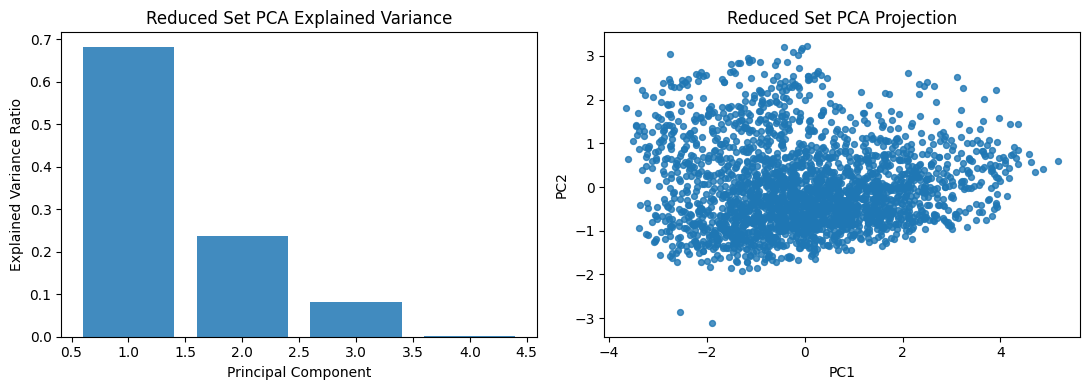

In [38]:

pca_reduced = PCA(random_state=RANDOM_SEED)
X_reduced_pca = pca_reduced.fit_transform(X_reduced_scaled)

explained_reduced = pca_reduced.explained_variance_ratio_

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].bar(np.arange(1, len(explained_reduced) + 1), explained_reduced, alpha=0.85)
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].set_title("Reduced Set PCA Explained Variance")

axes[1].scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], s=18, alpha=0.8)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title("Reduced Set PCA Projection")
fig.tight_layout()
plt.show()


### 9.4 Clustering in Reduced Marker Space

In [39]:

k_values_reduced = list(range(3, 9))
sil_reduced = []
models_reduced = {}

for k in k_values_reduced:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20)
    labels_k = km.fit_predict(X_reduced_scaled)
    score_k = silhouette_score(X_reduced_scaled, labels_k)
    sil_reduced.append(score_k)
    models_reduced[k] = (km, labels_k)

best_idx_reduced = int(np.argmax(sil_reduced))
best_k_reduced = k_values_reduced[best_idx_reduced]
best_model_reduced, reduced_labels = models_reduced[best_k_reduced]
best_silhouette_reduced = sil_reduced[best_idx_reduced]

df["cluster_reduced"] = reduced_labels

print("Reduced-space silhouette scores:")
for k, s in zip(k_values_reduced, sil_reduced):
    print(f"  K={k}: {s:.4f}")
print(f"Best K (reduced): {best_k_reduced}")
print(f"Best silhouette (reduced): {best_silhouette_reduced:.4f}")


Reduced-space silhouette scores:
  K=3: 0.3409
  K=4: 0.3095
  K=5: 0.3027
  K=6: 0.2811
  K=7: 0.2805
  K=8: 0.2772
Best K (reduced): 3
Best silhouette (reduced): 0.3409


### 9.5 Visualization

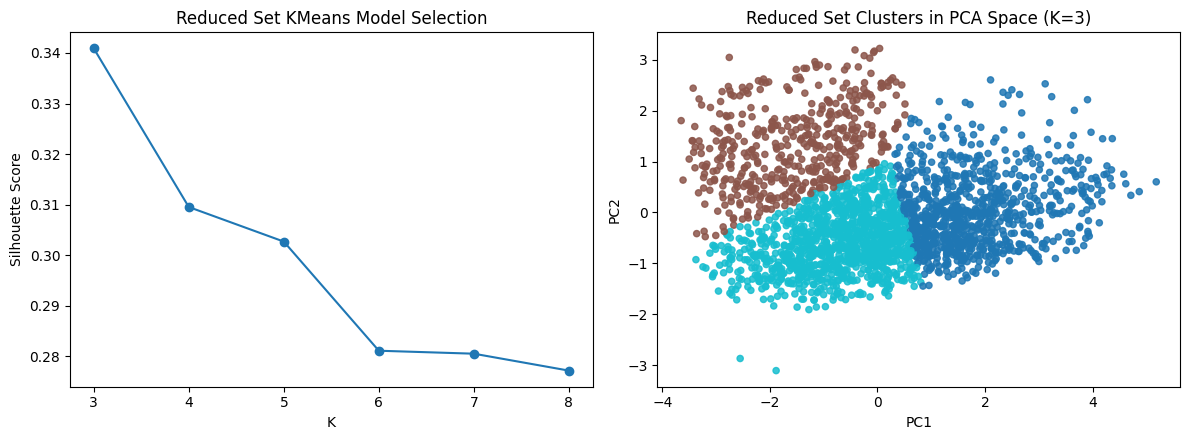

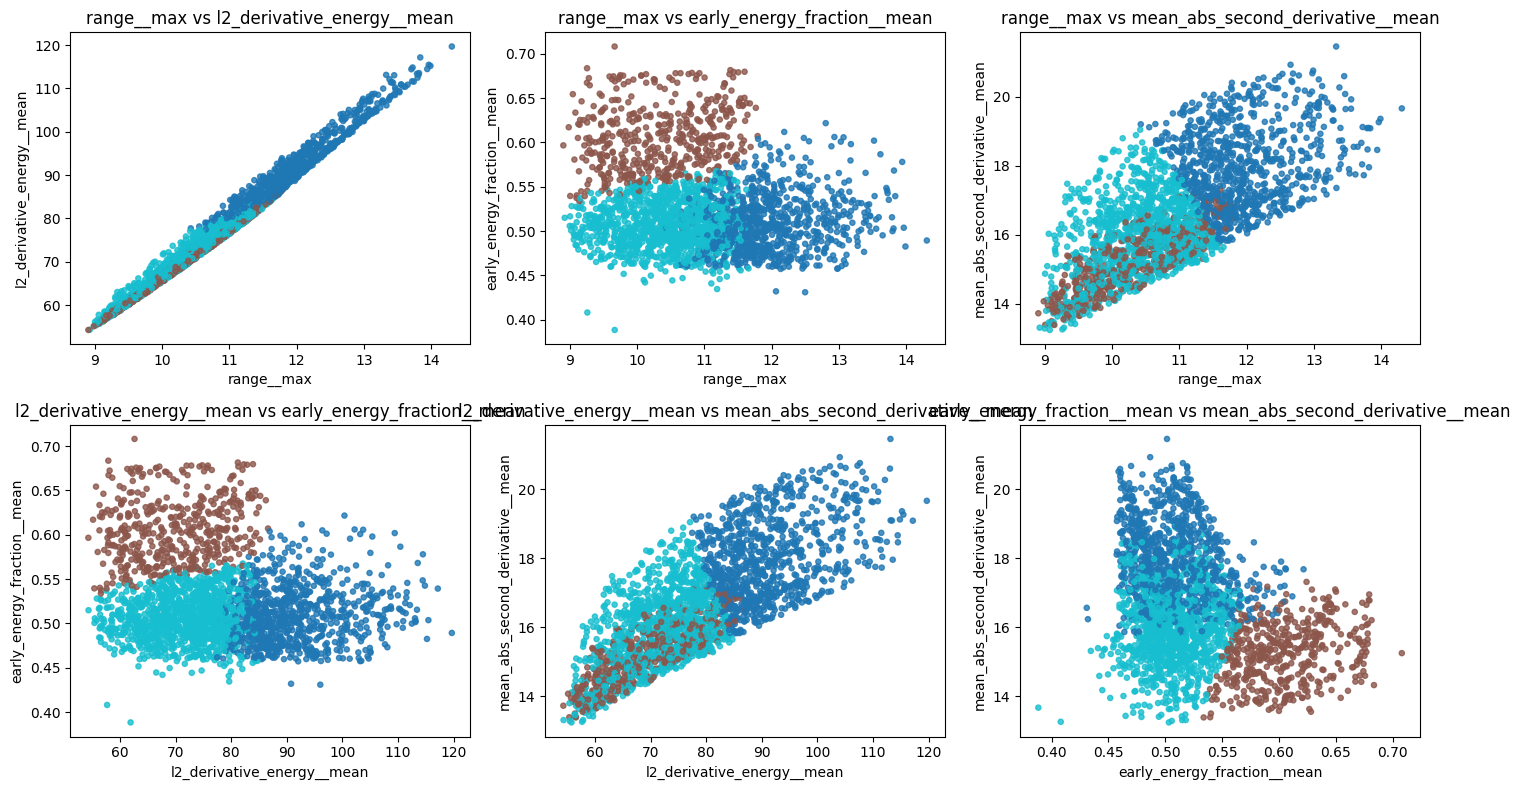

Reduced clustering - cluster sizes:


,n_trajectories
0,834
1,460
2,1106


In [40]:

# Clusters in reduced PCA space.
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
axes[0].plot(k_values_reduced, sil_reduced, marker="o")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Reduced Set KMeans Model Selection")

axes[1].scatter(
    X_reduced_pca[:, 0],
    X_reduced_pca[:, 1],
    c=reduced_labels,
    cmap="tab10",
    s=20,
    alpha=0.85,
)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title(f"Reduced Set Clusters in PCA Space (K={best_k_reduced})")
fig.tight_layout()
plt.show()

# Pairwise scatter plots of selected markers.
from itertools import combinations

pairs = list(combinations(selected_markers, 2))
if not pairs:
    print("Not enough markers for pairwise scatter plots.")
else:
    n_cols = 3
    n_rows = int(np.ceil(len(pairs) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8 * n_cols, 4.0 * n_rows))
    axes = np.atleast_1d(axes).ravel()
    for ax, (a, b) in zip(axes, pairs):
        ax.scatter(df[a], df[b], c=reduced_labels, cmap="tab10", s=14, alpha=0.8)
        ax.set_xlabel(a)
        ax.set_ylabel(b)
        ax.set_title(f"{a} vs {b}")
    for ax in axes[len(pairs):]:
        ax.axis("off")
    fig.tight_layout()
    plt.show()

cluster_sizes_reduced = pd.Series(reduced_labels).value_counts().sort_index()
print("Reduced clustering - cluster sizes:")
display(cluster_sizes_reduced.to_frame("n_trajectories"))


### 9.6 Interpretability Analysis

In [22]:

# Per-cluster marker summary (mean/std) for selected markers.
summary_rows = []
for c in sorted(np.unique(reduced_labels)):
    part = df.loc[df["cluster_reduced"] == c, selected_markers]
    for m in selected_markers:
        summary_rows.append(
            {
                "cluster": int(c),
                "marker": m,
                "mean": float(part[m].mean()),
                "std": float(part[m].std(ddof=0)),
            }
        )

cluster_marker_summary = pd.DataFrame(summary_rows)
print("Per-cluster marker mean/std:")
display(cluster_marker_summary)


Per-cluster marker mean/std:


,cluster,marker,mean,std
0,0,range__max,1.680545,0.221212
1,0,l2_derivative_energy__mean,4.391784,1.048429
2,0,early_energy_fraction__mean,0.560905,0.039479
3,0,mean_abs_second_derivative__mean,7.046150,0.791455
4,1,range__max,0.586421,0.193371
5,1,l2_derivative_energy__mean,0.535365,0.305527
6,1,early_energy_fraction__mean,0.618546,0.040288
7,1,mean_abs_second_derivative__mean,2.594322,0.902931
8,2,range__max,0.526325,0.207971
9,2,l2_derivative_energy__mean,0.398029,0.296118


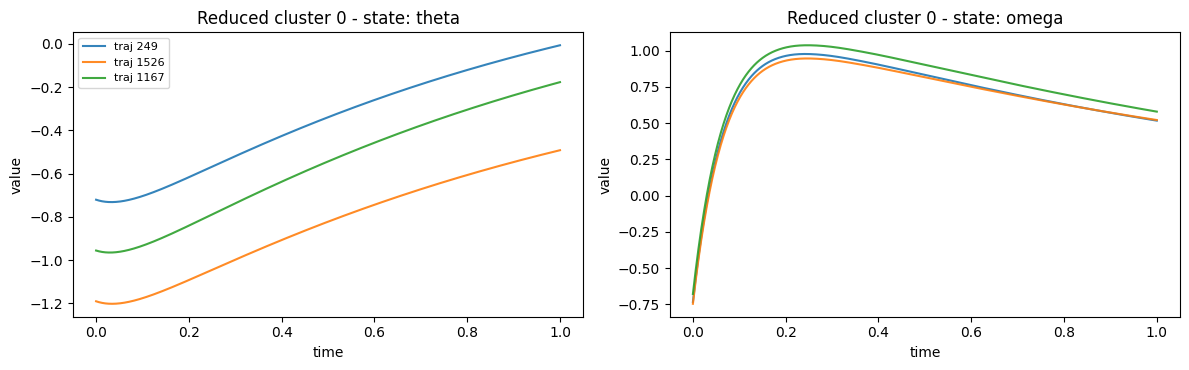

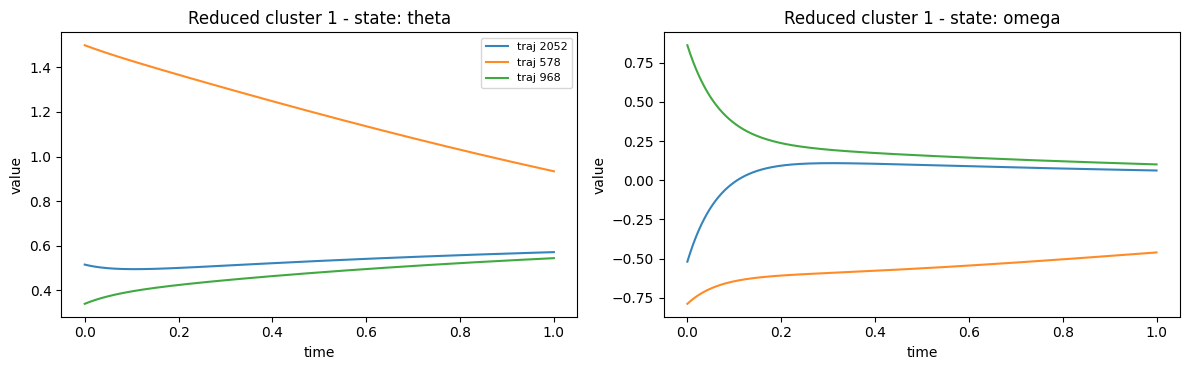

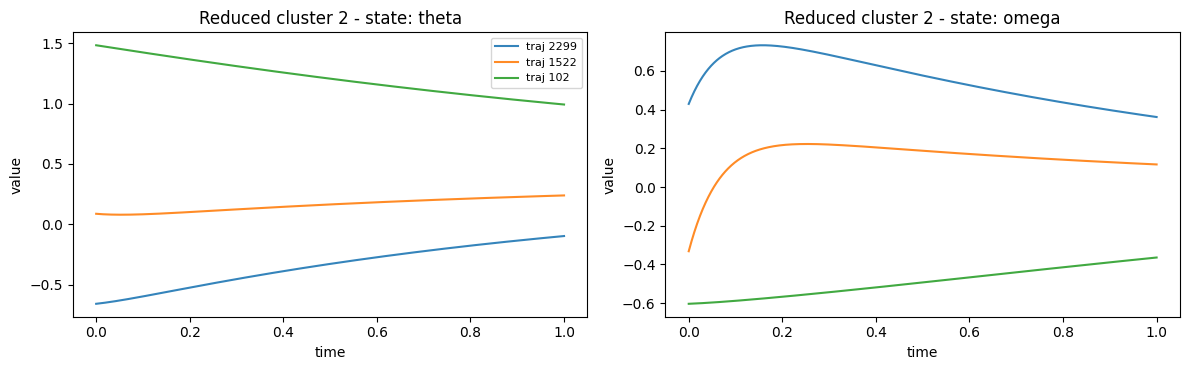

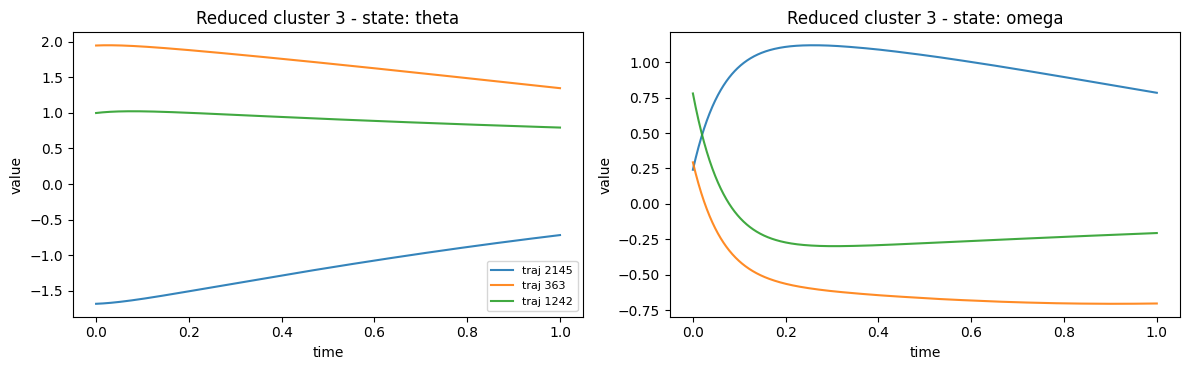

In [23]:

# Representative trajectories per reduced cluster (2-3 per cluster), key states only.
state_candidates = ["delta", "theta", "omega"]
plot_states = [s for s in state_candidates if s in state_names]
if not plot_states:
    plot_states = state_names[: min(2, len(state_names))]

state_to_idx = {s: i for i, s in enumerate(state_names)}
plot_state_idx = [state_to_idx[s] for s in plot_states]

X_reduced_2 = X_reduced_pca[:, :2]
centers_reduced_2 = best_model_reduced.cluster_centers_ @ pca_reduced.components_[:2, :].T

for c in sorted(np.unique(reduced_labels)):
    idx = np.where(reduced_labels == c)[0]
    if len(idx) == 0:
        continue

    d2 = np.sum((X_reduced_2[idx] - centers_reduced_2[c]) ** 2, axis=1)
    reps = idx[np.argsort(d2)[: min(3, len(idx))]]

    fig, axes = plt.subplots(1, len(plot_state_idx), figsize=(6 * len(plot_state_idx), 3.8), sharex=True)
    axes = np.atleast_1d(axes)

    for ax, s_idx in zip(axes, plot_state_idx):
        for rid in reps:
            ax.plot(time_grid, trajs[rid, :, s_idx], alpha=0.9, label=f"traj {rid}")
        ax.set_title(f"Reduced cluster {c} - state: {state_names[s_idx]}")
        ax.set_xlabel("time")
        ax.set_ylabel("value")

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(handles, labels, loc="best", fontsize=8)
    fig.tight_layout()
    plt.show()


In [37]:
df["cluster_reduced"].value_counts()

cluster_reduced
1    740
2    714
3    650
0    296
Name: count, dtype: int64

In [39]:
df.describe()

,ic_theta,ic_omega,ic_E_d_dash,ic_E_q_dash,ic_Vs,ic_theta_vs,range_theta,range_omega,range_E_d_dash,range_E_q_dash,range__mean,range__max,peak_deviation_theta,peak_deviation_omega,peak_deviation_E_d_dash,peak_deviation_E_q_dash,peak_deviation__mean,peak_deviation__max,total_variation_theta,total_variation_omega,total_variation_E_d_dash,total_variation_E_q_dash,total_variation__mean,total_variation__max,mean_abs_derivative_theta,mean_abs_derivative_omega,mean_abs_derivative_E_d_dash,mean_abs_derivative_E_q_dash,mean_abs_derivative__mean,mean_abs_derivative__max,l2_derivative_energy_theta,l2_derivative_energy_omega,l2_derivative_energy_E_d_dash,l2_derivative_energy_E_q_dash,l2_derivative_energy__mean,l2_derivative_energy__max,early_energy_fraction_theta,early_energy_fraction_omega,early_energy_fraction_E_d_dash,early_energy_fraction_E_q_dash,early_energy_fraction__mean,early_energy_fraction__max,mean_abs_second_derivative_theta,mean_abs_second_derivative_omega,mean_abs_second_derivative_E_d_dash,mean_abs_second_derivative_E_q_dash,mean_abs_second_derivative__mean,mean_abs_second_derivative__max,cluster_reduced
count,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2.400000e+03,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000
mean,-0.000003,-0.000004,0.0,1.000000,1.000000,-0.000001,0.521635,0.788615,0.0,0.008107,0.329589,0.868234,0.516912,0.779116,0.0,0.008056,0.326021,0.868234,0.526752,0.956219,0.0,0.008270,0.372810,0.995345,0.526752,0.956219,0.0,0.008270,0.372810,0.995345,0.386991,6.959889,0.0,1.040810e-04,1.836746,6.979002,0.274274,0.918176,0.0,0.291756,0.371051,0.924511,0.952877,12.363663,0.0,0.018561,3.333775,12.363806,1.715833
std,1.154948,0.577467,0.0,0.057747,0.028874,0.173240,0.308271,0.488932,0.0,0.005401,0.169855,0.447699,0.309833,0.497925,0.0,0.005452,0.170144,0.447699,0.306298,0.574142,0.0,0.005265,0.196209,0.546859,0.306298,0.574142,0.0,0.005265,0.196209,0.546859,0.374090,8.325244,0.0,1.119089e-04,2.125929,8.310321,0.198657,0.168533,0.0,0.192623,0.075410,0.145074,0.571314,8.610928,0.0,0.005386,2.293898,8.610729,0.996074
min,-1.998744,-0.999719,0.0,0.900013,0.950008,-0.299793,0.007404,0.014624,0.0,0.000059,0.008627,0.019768,0.007404,0.010929,0.0,0.000054,0.007704,0.019768,0.012935,0.018318,0.0,0.000070,0.009551,0.019768,0.012935,0.018318,0.0,0.000070,0.009551,0.019768,0.000186,0.000457,0.0,1.178078e-08,0.000218,0.000457,0.072304,0.007641,0.0,0.000687,0.092742,0.235127,0.020228,0.080608,0.0,0.009614,0.034102,0.080608,0.000000
25%,-0.999748,-0.499957,0.0,0.949990,0.975002,-0.149947,0.273570,0.412970,0.0,0.003501,0.203997,0.543564,0.266372,0.384424,0.0,0.003432,0.200618,0.543564,0.278726,0.514620,0.0,0.004047,0.219503,0.578649,0.278726,0.514620,0.0,0.004047,0.219503,0.578649,0.085048,0.871360,0.0,1.969072e-05,0.299532,0.920224,0.153879,0.943046,0.0,0.151589,0.320398,0.943046,0.513846,5.320635,0.0,0.012873,1.458889,5.320635,1.000000
50%,-0.000664,0.000264,0.0,1.000019,0.999990,-0.000013,0.489104,0.679239,0.0,0.007112,0.294420,0.785221,0.484000,0.679239,0.0,0.007112,0.286625,0.785221,0.494457,0.819009,0.0,0.007151,0.330237,0.877843,0.494457,0.819009,0.0,0.007151,0.330237,0.877843,0.253954,3.513368,0.0,6.024268e-05,0.957988,3.513368,0.197262,0.986780,0.0,0.227671,0.372479,0.986780,0.816144,10.659898,0.0,0.019297,2.873716,10.659898,2.000000
75%,0.999309,0.499679,0.0,1.049994,1.024996,0.149875,0.750288,1.087224,0.0,0.012121,0.433573,1.116192,0.743264,1.087224,0.0,0.012121,0.432969,1.116192,0.757043,1.321330,0.0,0.012121,0.505825,1.321330,0.757043,1.321330,0.0,0.012121,0.505825,1.321330,0.597447,


**Cluster interpretation notes (fill after visual inspection):**

- Do clusters map to visibly distinct trajectory shapes?
- Are cluster sizes balanced enough for downstream use?
- Is separation physically meaningful, or mostly an artifact of scaling/projection?


### 9.7 Comparison with Full Marker Set

In [33]:

from sklearn.metrics import adjusted_rand_score

# Full-space silhouette baseline: use existing values if available; otherwise recompute quickly.
if "best_silhouette_full" in globals():
    best_silhouette_full = float(best_silhouette_full)
elif "sil_scores" in globals():
    best_silhouette_full = float(np.max(sil_scores))
else:
    X_full = marker_table[marker_cols].to_numpy(dtype=np.float64)
    X_full_scaled = StandardScaler().fit_transform(X_full)
    sil_full_tmp = []
    for k in range(3, 9):
        l = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20).fit_predict(X_full_scaled)
        sil_full_tmp.append(silhouette_score(X_full_scaled, l))
    best_silhouette_full = float(np.max(sil_full_tmp))

# Full-space labels: reuse if available; otherwise infer with best_k from current notebook.
if "best_labels" in globals():
    full_labels = np.asarray(best_labels)
else:
    X_full = marker_table[marker_cols].to_numpy(dtype=np.float64)
    X_full_scaled = StandardScaler().fit_transform(X_full)
    k_full = int(np.argmax([silhouette_score(X_full_scaled, KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20).fit_predict(X_full_scaled)) for k in range(3, 9)]) + 3)
    full_labels = KMeans(n_clusters=k_full, random_state=RANDOM_SEED, n_init=20).fit_predict(X_full_scaled)

ari_reduced_vs_full = adjusted_rand_score(full_labels, reduced_labels)

comparison_df = pd.DataFrame(
    {
        "metric": ["best_silhouette_full", "best_silhouette_reduced", "adjusted_rand_full_vs_reduced"],
        "value": [best_silhouette_full, best_silhouette_reduced, ari_reduced_vs_full],
    }
)

print("Full vs reduced clustering comparison:")
display(comparison_df)


Full vs reduced clustering comparison:


,metric,value
0,best_silhouette_full,0.264561
1,best_silhouette_reduced,0.361018
2,adjusted_rand_full_vs_reduced,0.331301


### 9.8 Optional: Surrogate Error Link

In [34]:

# If an error vector/column exists, report correlation with cluster index and cluster-wise mean error.
# Priority:
# 1) 'surrogate_error' already in df
# 2) previously loaded 'err' vector

error_vec = None
if "surrogate_error" in df.columns:
    error_vec = df["surrogate_error"].to_numpy(dtype=float)
elif "err" in globals():
    err_arr = np.asarray(err, dtype=float)
    if err_arr.ndim == 1 and len(err_arr) == len(df):
        error_vec = err_arr

if error_vec is None:
    print("No trajectory-level error column/vector available. Skipping error-link analysis.")
else:
    corr_cluster_error = float(np.corrcoef(reduced_labels.astype(float), error_vec)[0, 1])
    err_df = pd.DataFrame({"cluster_reduced": reduced_labels, "surrogate_error": error_vec})
    per_cluster_error = err_df.groupby("cluster_reduced")["surrogate_error"].agg(["mean", "std", "count"]).reset_index()

    print(f"Correlation(cluster_label, surrogate_error): {corr_cluster_error:.4f}")
    display(per_cluster_error)


No trajectory-level error column/vector available. Skipping error-link analysis.


### 9.9 Short Summary

In [35]:

is_sufficient = best_silhouette_reduced >= 0.85 * best_silhouette_full
is_stable = ari_reduced_vs_full >= 0.5

print("Reduced marker set summary")
print("--------------------------")
print(f"Selected markers: {selected_markers}")
print(f"Best silhouette (full):    {best_silhouette_full:.4f}")
print(f"Best silhouette (reduced): {best_silhouette_reduced:.4f}")
print(f"Adjusted Rand Index:       {ari_reduced_vs_full:.4f}")
print(f"Reduced set sufficient?    {'Yes' if is_sufficient else 'Partially/No'}")
print(f"Clusters stable?           {'Yes' if is_stable else 'Moderate/Low'}")
print("Regime diversity captured? See PCA/pairwise plots + representative trajectories above.")


Reduced marker set summary
--------------------------
Selected markers: ['range__max', 'l2_derivative_energy__mean', 'early_energy_fraction__mean', 'mean_abs_second_derivative__mean']
Best silhouette (full):    0.2646
Best silhouette (reduced): 0.3610
Adjusted Rand Index:       0.3313
Reduced set sufficient?    Yes
Clusters stable?           Moderate/Low
Regime diversity captured? See PCA/pairwise plots + representative trajectories above.
